In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/CV projects/Retinal Disease Classification'

/content/drive/My Drive/CV projects/Retinal Disease Classification


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os

import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import skimage.io as io



In [ ]:
if not os.path.exists('retina_dataset'):
  #Restore all data from Google Drive to virtual Colab machine with File ID
  zip_id = '1Nl4rhnP_22dJc_mbWvc4mv3e9Kmsv5JU' 
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  print ("retinal_disease_classificaton.zip ...")
  myzip = drive.CreateFile({'id': zip_id})
  myzip.GetContentFile('retinal_disease_classificaton.zip')

  print ("Uncompressing vietai_advance_w1b_retinal_disease_classificaton.zip ...")
  if not os.path.exists('retina_dataset'):
      os.makedirs('retina_dataset')
  zip_ref = zipfile.ZipFile('retinal_disease_classificaton.zip', 'r')
  zip_ref.extractall('retina_dataset')
  zip_ref.close()
  os.remove("retinal_disease_classificaton.zip")

os.listdir("retina_dataset")

['baseline_model', 'sample_submission.csv', 'test', 'train.csv', 'train']

# Data analyzing

In [ ]:
data = pd.read_csv('retina_dataset/train.csv')
print(f'{len(data)} samples total')
data.head()

3435 samples total


,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [ ]:
# Distribution of labels
for label in data.columns[1:]:
  print('Distribution of' + label)
  print(data[label].value_counts())

Distribution ofopacity
0    1902
1    1533
Name: opacity, dtype: int64
Distribution ofdiabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution ofglaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution ofmacular edema
0    2919
1     516
Name: macular edema, dtype: int64
Distribution ofmacular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64
Distribution ofretinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64
Distribution ofnormal
0    2910
1     525
Name: normal, dtype: int64


In [ ]:
LABELS = data.columns[1:]
LABELS

Index(['opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema',
       'macular degeneration', 'retinal vascular occlusion', 'normal'],
      dtype='object')

In [ ]:
# Combination of labels
def build_label(row):
  return [LABELS[idx] for idx, value in enumerate(row[1:]) if value == 1]

data['label'] = data.apply(lambda x: build_label(x), axis = 1) # row
data['label'].apply(lambda x : ','.join(x)).value_counts()

opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
diabetic retinopathy                                                     212
opacity,macular degeneration                                             212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62

In [ ]:
# Split train/val
train_data, val_data = train_test_split(data, test_size= 0.2, random_state= 2020)
print(f'{len(train_data)} training samples')
print(f'{len(val_data)} validation samples')

2748 training samples
687 validation samples


In [ ]:
TRAIN_DIR = 'retina_dataset/train/train'
TEST_DIR = 'retina_dataset/test/test'

'opacity'

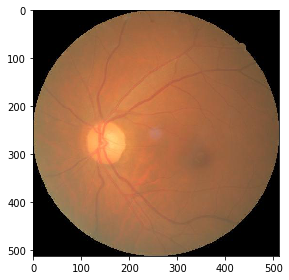

In [ ]:
# Read an image
image_file = os.listdir(TRAIN_DIR)[0]
image_label = data.loc[data['filename'] == image_file].iloc[0]['label']

image= io.imread(f'{TRAIN_DIR}/{image_file}')
io.imshow(image)
','.join(image_label)

# Data generator

In [ ]:
# Hyperparameter
IMAGE_SIZE = 224
BATCH_SIZE = 64
LR = 1e-03
NUM_EPOCH = 100

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center= True,
                                                       samplewise_center= True)

In [ ]:
train_gen = datagen.flow_from_dataframe(dataframe= train_data,
                                        directory= TRAIN_DIR,
                                        x_col= 'filename',
                                        y_col= 'label',
                                        target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                        class_mode= 'categorical',
                                        batch_size= BATCH_SIZE,
                                        shuffle= True)

val_gen = datagen.flow_from_dataframe(dataframe= val_data,
                                        directory= TRAIN_DIR,
                                        x_col= 'filename',
                                        y_col= 'label',
                                        target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                        class_mode= 'categorical',
                                        batch_size= BATCH_SIZE,
                                        shuffle= False)

Found 2748 validated image filenames belonging to 7 classes.
Found 687 validated image filenames belonging to 7 classes.


# Define Model

In [ ]:
base_model = keras.applications.ResNet50(include_top= False,
                                         weights= 'imagenet',
                                         input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3))

base_model.trainable = True

model = keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(len(LABELS), activation= 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


# Training phase

In [ ]:
# define callbacks
mcp = keras.callbacks.ModelCheckpoint(filepath= 'resnet50.h5',
                                      monitor= 'val_f1',
                                      verbose= 1,
                                      save_best_only= True,
                                      save_weights_only= True,
                                      mode= 'max') # Model checkpoint

rlr = keras.callbacks.ReduceLROnPlateau(monitor= 'val_f1',
                                        factor= 0.1,
                                        patience= 5,
                                        verbose= 1,
                                        mode= 'max',
                                        min_lr= 1e-08)
callbacks = [mcp, rlr]


In [ ]:
# f1 score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
device = '/gpu:0'

with tf.device(device):
  model.compile(optimizer= keras.optimizers.Adam(learning_rate= LR), loss= 'binary_crossentropy', metrics= [f1])
  model.fit_generator(generator= train_gen,                      
                      steps_per_epoch= np.ceil(train_gen.n/BATCH_SIZE),
                      epochs= NUM_EPOCH,
                      verbose= 1,
                      callbacks= callbacks,
                      validation_data= val_gen,
                      validation_steps= np.ceil(val_gen.n/BATCH_SIZE)
                      )

NameError: ignored

# Inference

In [ ]:
test_data = pd.read_csv('retina_dataset/sample_submission.csv')
test_data.head()

,filename,predicted
0,e742d34a26d4.jpg,0 0
1,b193b6a6d68d.jpg,0 0
2,07e4191fa3a8.jpg,0 0
3,b1a911cb2e6c.jpg,0 0
4,d8ab9cda1b33.jpg,0 0


In [ ]:
model.load_weights('resnet50.h5')


In [ ]:
test_gen = datagen.flow_from_dataframe(dataframe= test_data,
                                       directory= TEST_DIR,
                                       x_col= 'filename',
                                       target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                       class_mode=None,
                                       batch_size= BATCH_SIZE,
                                       shuffle= False)

Found 350 validated image filenames.


In [ ]:
pred = model.predict_generator(generator = test_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
train_gen.class_indices()

NameError: ignored